In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, SelectKBest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import warnings
import pickle
import shap
import os
warnings.filterwarnings("ignore")

In [30]:
# import sys
# !{sys.executable} -m pip install --force-reinstall scikit-learn==1.4.0
# Fix numpy to work with numba: install --force-reinstall 'numpy<2.1'

In [2]:
def select_top_k_features_MI(X, y, k=100):
    selected_features = {}
    mutual_info_selector = SelectKBest(mutual_info_classif, k=k)
    mutual_info_selector.fit(X, y)
    selected_features['mutual_information'] = mutual_info_selector.get_support(indices=True)
    print(f"mutual_information: {selected_features['mutual_information']}")
    return selected_features

In [3]:
def grid_search(estimator, param_grid, X_train, y_train, scoring='f1'):
    grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, scoring=scoring, cv=None, refit=True)
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
    print(f"Best Hyperparameters: {best_params}")
    return best_params, best_model

In [4]:
def plotTree(dt_model, feature_names, file_name, plot_title):
    plt.figure()
    plot_tree(dt_model, class_names=["grade 2", "grade 3"],  
              filled=True, rounded=True,
              feature_names=feature_names)
    plt.title(plot_title)
    plt.savefig(f"{file_name}.pdf")

def plot_sorted_coefs(sorted_labels, sorted_values, file_name, plot_title):
    plt.figure(figsize=(20, 5))
    plt.bar(sorted_labels, sorted_values, color='skyblue')
    plt.xlabel('Genes')
    plt.ylabel('Values')
    plt.title(plot_title)
    plt.xticks(rotation=45)
    plt.savefig(f"{file_name}.pdf")

Grade prediction for ER+ HER2-
==
### Feature selection (MI), top 2000 (10% most relevant genes) --> train classifier --> select top-k features

In [5]:
# read data
df = pd.read_csv("METABRIC.csv")
print('# Total rows:', df["GRADE"].value_counts())
df = df[df['GRADE'].notna()]
print('# Rows with GRADE 1-2-3:', df["GRADE"].value_counts())
df = df[df['GRADE']!=1]
print('# Rows with GRADE 2-3:', df["GRADE"].value_counts())

# keep grade, status, and genetic data
ER_STATUS, HER2_STATUS, PR_STATUS = 5, 6, 9
grade_column = df['GRADE']
columns_to_keep = df.columns[[ER_STATUS, HER2_STATUS, PR_STATUS]]
columns_to_drop = df.columns[:36].difference(columns_to_keep)
df = df.drop(columns=columns_to_drop)
df.insert(0, 'GRADE', grade_column)
df['ER_STATUS'] = df['ER_STATUS'].map({'Positive': 1, 'Negative': 0})
df['HER2_STATUS'] = df['HER2_STATUS'].map({'Positive': 1, 'Negative': 0})
df['PR_STATUS'] = df['PR_STATUS'].map({'Positive': 1, 'Negative': 0})
print(f"shape:{df.shape}")

# clean null values
df = df[~np.any(pd.isna(df), axis=1)]
print('After cleaning NULL values:', df["GRADE"].value_counts())

# mask values
mask = (df['ER_STATUS'] == 1) & (df['HER2_STATUS'] == 0)
er_pos_df = df.loc[mask]
y_er_pos = er_pos_df['GRADE'].values
x_er_pos = er_pos_df.drop('GRADE', axis=1)
x_er_pos = x_er_pos.iloc[:,6:]
print(f"shape:{x_er_pos.shape}")
print(er_pos_df["GRADE"].value_counts())

feature selection
print("\nselecting top-2000 (top 10%) genes with mutual information...")
feature_selection_map_er_pos = select_top_k_features_MI(x_er_pos, y_er_pos, k=2000) ## select 10% most relevant genes
indexes = feature_selection_map_er_pos['mutual_information']
cols_filtered = x_er_pos.columns[indexes]
print(cols_filtered)
x_er_pos_MI = x_er_pos.values[:, indexes]
print(x_er_pos_MI.shape)

# Total rows: GRADE
3.0    952
2.0    771
1.0    169
Name: count, dtype: int64
# Rows with GRADE 1-2-3: GRADE
3.0    952
2.0    771
1.0    169
Name: count, dtype: int64
# Rows with GRADE 2-3: GRADE
3.0    952
2.0    771
Name: count, dtype: int64
shape:(1723, 20610)
After cleaning NULL values: GRADE
3.0    948
2.0    764
Name: count, dtype: int64
shape:(1160, 20603)
GRADE
2.0    669
3.0    491
Name: count, dtype: int64


## Decision Tree

In [6]:
SEEDS = [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71,
73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151,
157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 229, 233,
239, 241, 251, 257, 263, 269, 271, 277, 281, 283, 293, 307, 311, 313, 317,
331, 337, 347, 349, 353, 359, 367, 373, 379, 383, 389, 397, 401, 409, 419,
421, 431, 433, 439, 443, 449, 457, 461, 463, 467, 479, 487, 491, 499, 503,
509, 521, 523, 541] # first 100 primes

feat_imp = np.zeros(2000)
f1_macro = 0.0

# dt_models = []

### train models (uncomment to train) ###
# trial = 0
# for seed in SEEDS:
#     print(f"trial {trial}/{len(SEEDS)}")
#     trial += 1
#     X_train, X_test, y_train, y_test = train_test_split(x_er_pos_MI, y_er_pos, test_size=0.2, random_state=seed, stratify=y_er_pos)
#     # print(f"train shape:{X_train.shape}")
#     # print(f"test shape:{X_test.shape}")
#     dt_model = DecisionTreeClassifier()
#     param_grid = { 
#         'max_depth' : [2],#,3],
#         'criterion' :['gini'],#, 'entropy'],
#         'random_state' : [seed]
#     }
#     best_params, best_dt_model = grid_search(dt_model, param_grid, X_train, y_train, scoring="f1")
#     dt_models.append(best_dt_model)
#     y_pred = best_dt_model.predict(X_test)
#     f1_m = f1_score(y_test, y_pred, average='macro')
#     f1_macro += f1_m
#     # print(f"f1 macro: {f1_m}")
#     imp = best_dt_model.feature_importances_
#     feat_imp += imp
#     indices_sort = sorted(range(len(imp)), key=lambda i: imp[i], reverse=True)[:3]
    # print("Feature importance:")
    # for i in indices_sort:
    #     print(f"- {cols_filtered[i]}: {imp[i]}")
    # print("***********************\n")
    # plotTree(best_dt_model, cols_filtered.to_list(), f"dt_plots/dt_ER_pos_MI_{seed}", "Decision Tree ER Positive + MI")

### save models and data (uncomment to save) ###
# with open("models.pkl", "wb") as file:
#     pickle.dump(dt_models, file)
    
# with open("data.pkl", "wb") as file:
#     pickle.dump((x_er_pos_MI, y_er_pos, cols_filtered), file)
    
# ### global metrics ###
# print("Global metrics:")
# print(f"Average f1 macro: {f1_macro/len(SEEDS)}")
# feat_imp/=len(SEEDS)
# print("Average feature importance:")
# indices_sort = sorted(range(len(feat_imp)), key=lambda i: feat_imp[i], reverse=True)[:10]
# for i in indices_sort:
#     print(f"- {cols_filtered[i]}: {feat_imp[i]}")
# print()

In [36]:
# genes = []
# values = []
# for i in indices_sort:
#     genes.append(cols_filtered[i])
#     values.append(feat_imp[i])
    
# plt.figure(figsize=(10, 6))
# plt.bar(genes, values, color='skyblue', edgecolor='black')
# plt.xlabel('Genes', fontsize=12)
# plt.ylabel('Values', fontsize=12)
# plt.title('Gene Expression Values', fontsize=14)
# plt.xticks(rotation=45, fontsize=10)
# plt.tight_layout()
# plt.show()

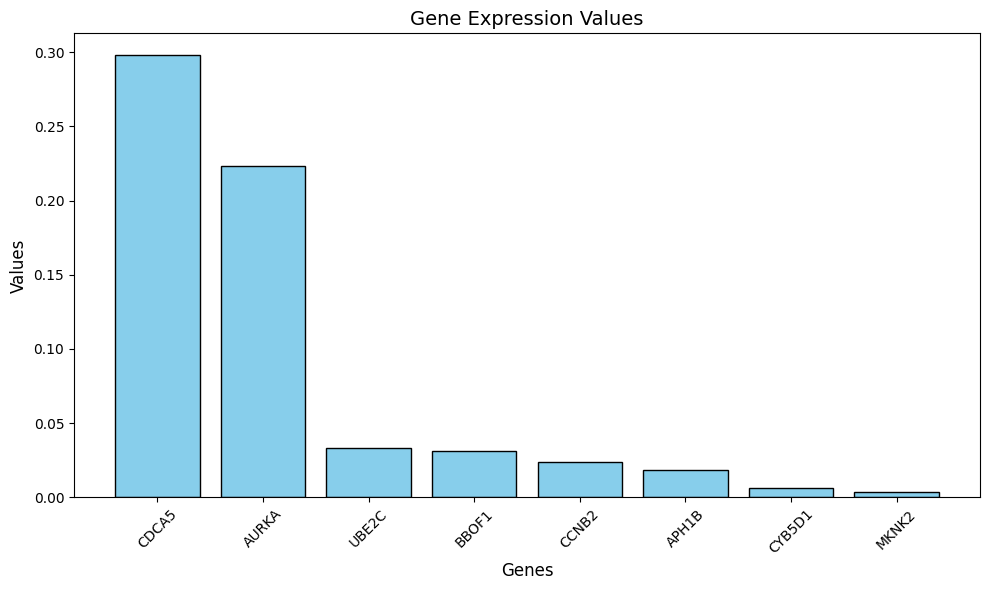

In [8]:
genes = []
values = []
# for i in indices_sort:
#     genes.append(cols_filtered[i])
#     values.append(feat_imp[i])
    
### dict (reference values reported, experimental analysis) ###
genes = ['CDCA5', 'AURKA', 'UBE2C', 'BBOF1', 'CCNB2', 'APH1B', 'CYB5D1', 'MKNK2'] ### used genes in previous tests
values = [0.29779838031578415, 0.22322252215741184, 0.03299119659738872, 0.03106685238187796, 
          0.02390827074695493, 0.018709906714336814, 0.0062486250794349385, 0.0038298311953484478]
    
plt.figure(figsize=(10, 6))
plt.bar(genes, values, color='skyblue', edgecolor='black')
plt.xlabel('Genes', fontsize=12)
plt.ylabel('Values', fontsize=12)
plt.title('Gene Expression Values', fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.savefig("plot_expression.pdf", bbox_inches='tight')
plt.show()

In [42]:
### load models and data ###
with open("models.pkl", "rb") as file:
    loaded_model_list = pickle.load(file)
n_models = len(loaded_model_list)

### load data ###
with open("data.pkl", "rb") as file:
    data = pickle.load(file)
x_er_pos_MI, y_er_pos, cols_filtered = data

OFFSET = 2

def predict_ens(batch):
    # pred_sum = np.zeros(len(batch))
    # for dt_model in loaded_model_list:
    #     preds = dt_model.predict(batch)-OFFSET
    #     pred_sum += preds
    # threshold = np.ceil(n_models/2)
    # y_pred = np.array([int(s>=threshold) for s in pred_sum])+OFFSET
    # return y_pred
    y_pred_proba = predict_proba_ens(batch)
    return np.argmax(y_pred_proba, axis=1)+OFFSET

def predict_proba_ens(batch):
    pred_sum = np.zeros((len(batch),2))
    for dt_model in loaded_model_list:
        preds = dt_model.predict_proba(batch)
        pred_sum += preds
    preds_avg = pred_sum/n_models
    return preds_avg

In [43]:
### predict on test ###
X_train, X_test, y_train, y_test = train_test_split(x_er_pos_MI, y_er_pos, test_size=0.2, random_state=111, stratify=y_er_pos)
y_pred = predict_ens(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(f"F-score: {f1_score(y_test, y_pred, average='macro'):.2f}")

#### LATEST ####
# Accuracy: 0.75
# F-score: 0.74 
################

Accuracy: 0.76
F-score: 0.75


In [39]:
CDCA5_idx = cols_filtered.tolist().index("CDCA5")
AURKA_idx = cols_filtered.tolist().index("AURKA")
UBE2C_idx = cols_filtered.tolist().index("UBE2C")
CCNB2_idx = cols_filtered.tolist().index("CCNB2")

BBOF1_idx = cols_filtered.tolist().index("BBOF1")
APH1B_idx = cols_filtered.tolist().index("APH1B")
CYB5D1_idx = cols_filtered.tolist().index("CYB5D1")
MKNK2_idx = cols_filtered.tolist().index("MKNK2")

genes_idx = [
CDCA5_idx,
AURKA_idx,
UBE2C_idx,
CCNB2_idx,
BBOF1_idx,
APH1B_idx,
CYB5D1_idx,
MKNK2_idx
]

names = ["CDCA5", "AURKA", "UBE2C", "CCNB2", "BBOF1", "APH1B", "CYB5D1", "MKNK2"]

In [147]:
########## COMPACT MODEL TRAINING ##########

X_train, X_test, y_train, y_test = train_test_split(x_er_pos_MI, y_er_pos, test_size=0.2, random_state=111, stratify=y_er_pos)
y_train_pred = predict_ens(X_train) # use ensemble preds as target

X_train_8_genes = X_train[:, genes_idx]
X_test_8_genes = X_test[:, genes_idx]
cols_filtered_8_genes = cols_filtered[genes_idx]

depth = 5
compact_model = GradientBoostingClassifier(n_estimators= 50, max_depth=depth)
compact_model.fit(X_train_8_genes, y_train)
y_pred = compact_model.predict(X_test_8_genes)
f1_m = f1_score(y_test, y_pred, average='macro')
print(f"f1 macro: {f1_m}")


compact_model_dist = GradientBoostingClassifier(n_estimators= 50, max_depth=depth)
compact_model_dist.fit(X_train_8_genes, y_train_pred)
y_pred2 = compact_model_dist.predict(X_test_8_genes)
f1_m2 = f1_score(y_test, y_pred2, average='macro')
print(f"f1 macro dist: {f1_m2}")

best_compact_model = compact_model if f1_m >= f1_m2 else compact_model_dist

imp = best_compact_model.feature_importances_
indices_sort = sorted(range(len(imp)), key=lambda i: imp[i], reverse=True)
print("\nFeature importance (best compact model):")
for i in indices_sort:
    print(f"- {cols_filtered_8_genes[i]}: {imp[i]}")
print("***********************\n")
#plotTree(best_compact_model, cols_filtered_8_genes.to_list(), f"dt_plots/dt_ER_pos_MI_compact", "Decision Tree ER Positive + MI (compact)")

## save models (uncomment to train) ###
# with open("compact_model.pkl", "wb") as file:
#     pickle.dump(best_compact_model, file)

f1 macro: 0.6849295631904326
[2 2 2 2 3 3 3 2 2 2 2 2 2 3 3 2 3 2 3 2 2 3 2 3 2 2 2 2 3 2 2 2 3 2 2 2 3
 3 3 3 2 3 2 2 2 3 3 3 2 2 2 3 3 2 2 2 2 2 2 2 2 3 2 3 3 2 2 2 3 3 2 2 2 3
 2 2 3 2 2 2 2 3 3 3 3 2 2 3 2 2 2 3 2 2 2 3 3 2 3 2 2 3 2 2 2 2 3 2 2 3 2
 2 2 2 3 3 2 2 2 2 2 2 3 2 2 3 2 2 3 2 2 3 2 2 2 3 2 2 2 2 2 2 3 2 3 3 2 3
 2 3 2 2 3 2 2 2 3 2 2 3 2 2 2 2 2 3 2 3 3 2 2 2 2 3 2 3 2 2 2 2 2 2 2 3 2
 2 2 2 2 2 3 2 2 2 2 3 2 2 3 2 3 2 3 2 3 2 3 3 2 2 3 2 2 2 3 3 2 2 2 2 2 3
 3 2 3 2 3 3 2 3 2 3]
f1 macro dist: 0.7214118388157248

Feature importance (best compact model):
- CDCA5: 0.7161046344211336
- AURKA: 0.12833476032170058
- APH1B: 0.050130730375877015
- MKNK2: 0.030471218554713724
- CCNB2: 0.026885479361460476
- UBE2C: 0.024843329687661203
- BBOF1: 0.012108234975836858
- CYB5D1: 0.011121612301616558
***********************



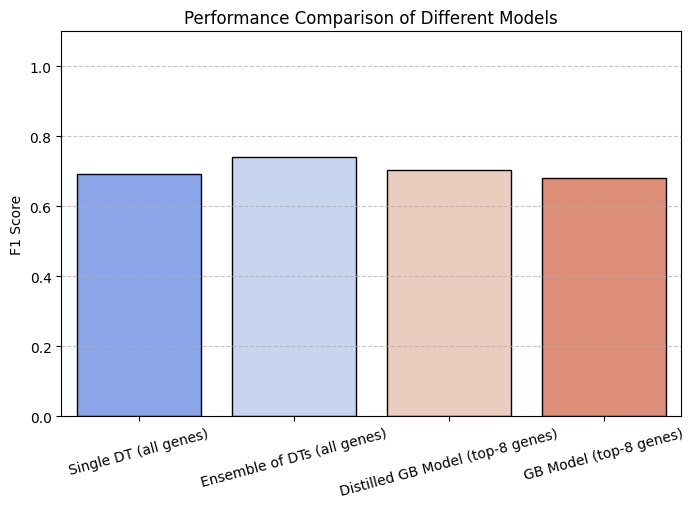

In [145]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data
tree_min = 0.598
tree_max = 0.740
tree_median = 0.694
tree_std = 0.035
ens_global = 0.742
compact_model = 0.704
gb_top8 = 0.68

models = ["Single DT (all genes)", "Ensemble of DTs (all genes)", "Distilled GB Model (top-8 genes)", "GB Model (top-8 genes)"]
values = [tree_median, ens_global, compact_model, gb_top8]
errors = [(tree_median - tree_min, tree_max - tree_median), (0, 0), (0, 0), (0, 0)]  # Error bars as (min_diff, max_diff)

# Convert errors to NumPy array for correct shape
errors = np.array(errors, dtype=object)

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=models, y=values, palette="coolwarm", edgecolor="black")

# Labels and aesthetics
plt.ylabel("F1 Score")
plt.title("Performance Comparison of Different Models")
plt.ylim(0, 1.1)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xticks(rotation=15)
plt.savefig("comparison_metabric.pdf", bbox_inches='tight')
plt.show()

In [146]:
# comparison
with open("compact_model.pkl", "rb") as file:
    cmodel = pickle.load(file)
    
# f1s from the ensemble
f1s = []
for model in loaded_model_list:
    f1s.append(f1_score(y_test, model.predict(X_test), average='macro'))
f1s = np.array(f1s)
print(f"Ens single: min f1:{np.min(f1s):.3f}; max f1:{np.max(f1s):.3f}; median f1:{np.median(f1s):.3f}; std dev:{np.std(f1s):.3f}")
print(f"Ens global: {f1_score(y_test, predict_ens(X_test), average='macro'):.3f}")
print(f"compact model: {f1_score(y_test, cmodel.predict(X_test_8_genes), average='macro'):.3f}")

Ens single: min f1:0.598; max f1:0.740; median f1:0.694; std dev:0.035
Ens global: 0.750
compact model: 0.729


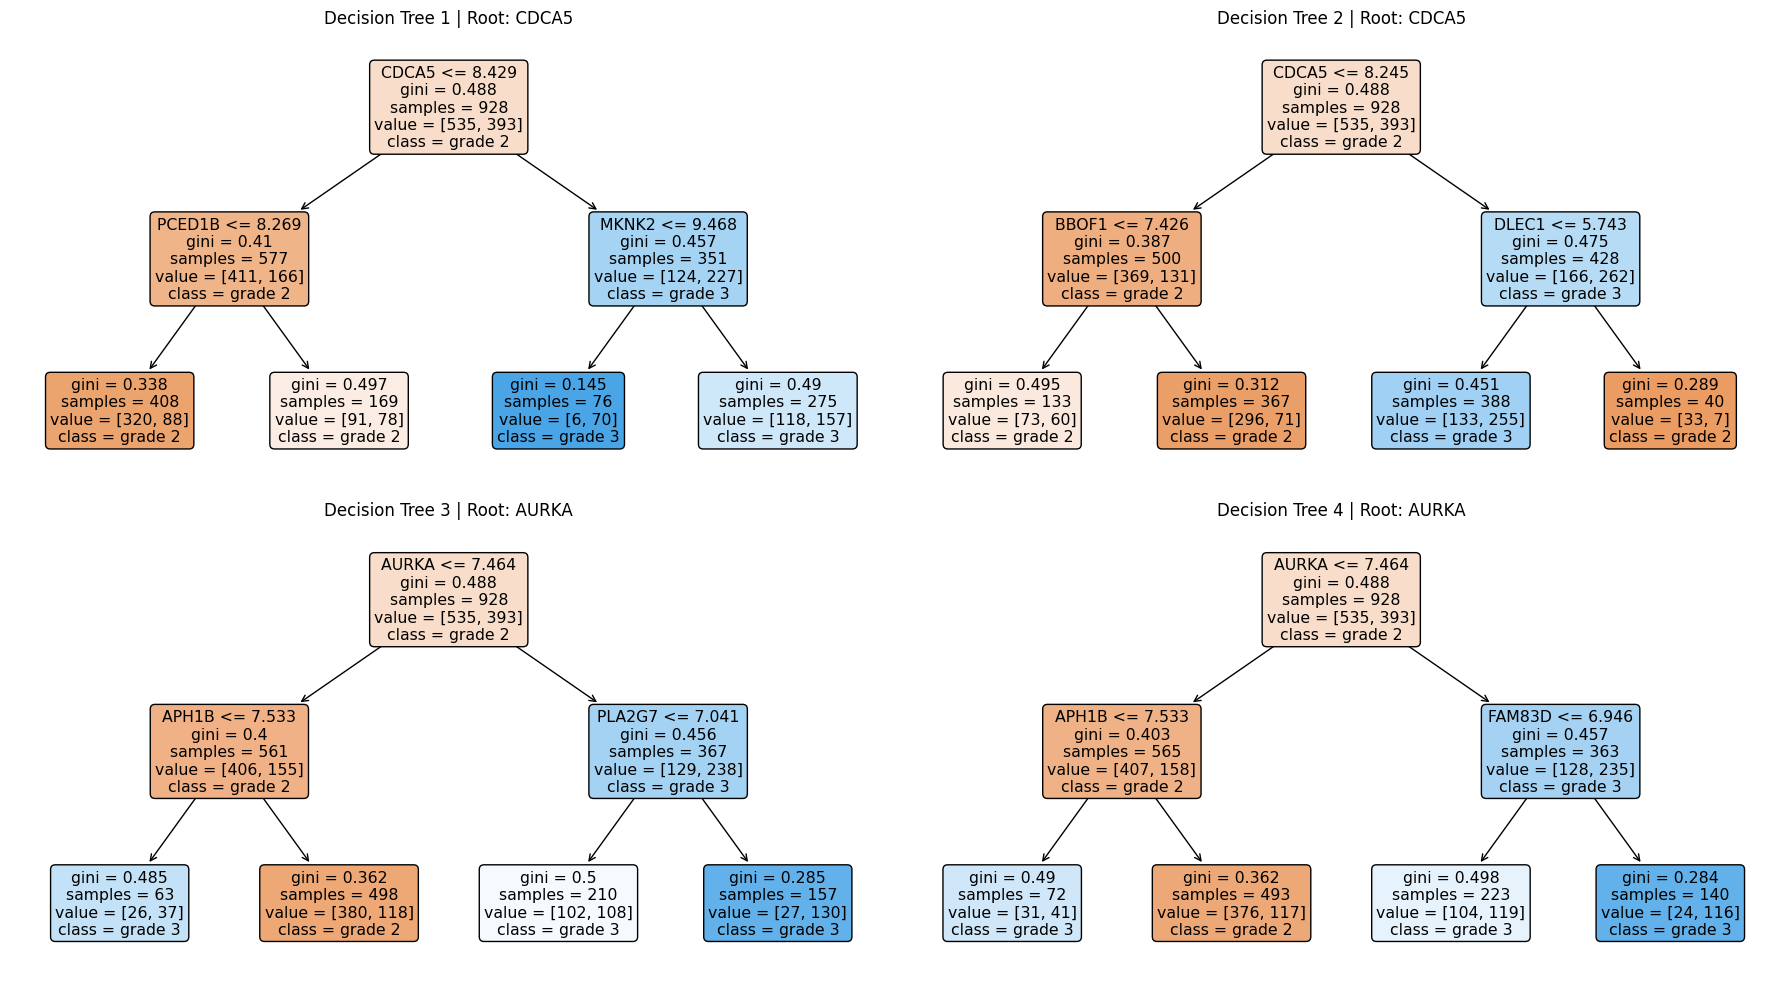

In [139]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import f1_score

# List of genes to filter on
target_genes = {"APH1B", "MKNK2", "CCNB2", "UBE2C", "CYB5D1", "BBOF1"}

# Helper functions
def get_used_features(model, feature_names):
    features = model.tree_.feature
    used_features = {feature_names[i] for i in features if i != -2}
    return used_features

def get_root_feature_name(model, feature_names):
    root_index = model.tree_.feature[0]
    return feature_names[root_index] if root_index != -2 else None

# Compute F1 scores and filter based on used genes
model_scores = []
for model in loaded_model_list:
    used_features = get_used_features(model, cols_filtered.tolist())
    if used_features & target_genes:  # Intersection not empty
        score = f1_score(y_test, model.predict(X_test), average='macro', pos_label = 3)
        model_scores.append((model, score))

# Filter models by root
cdca5_models = [(model, score) for model, score in model_scores
                if get_root_feature_name(model, cols_filtered.tolist()) == "CDCA5"]
aurka_models = [(model, score) for model, score in model_scores
                if get_root_feature_name(model, cols_filtered.tolist()) == "AURKA"]

# Get top 2 from each group
cdca5_top2 = sorted(cdca5_models, key=lambda x: x[1], reverse=True)[:2]
aurka_top2 = sorted(aurka_models, key=lambda x: x[1], reverse=True)[:2]
top_models = cdca5_top2 + aurka_top2

# Plotting
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
axes = axes.flatten()

for i, (dt_model, score) in enumerate(top_models):
    plot_tree(dt_model, ax=axes[i], class_names=["grade 2", "grade 3"],
              filled=True, rounded=True, feature_names=cols_filtered.tolist())
    root_feature = get_root_feature_name(dt_model, cols_filtered.tolist())
    axes[i].set_title(f"Decision Tree {i+1} | Root: {root_feature}")

plt.tight_layout()
plt.savefig("decision_trees.pdf", bbox_inches='tight')


In [140]:
with open("compact_model.pkl", "rb") as file:
    cmodel = pickle.load(file)
predictions = cmodel.predict(X_test_8_genes)

explainer = shap.Explainer(cmodel.predict, X_train_8_genes, feature_names=names)
def explain(sample_id):
    save_path=f'report/{sample_id}/shap_values_bar_plot_{sample_id}.png'
    sample = X_test_8_genes[sample_id].reshape(1, -1)
    expl = explainer(sample)[0]
    fig = shap.plots.bar(expl, show=False)
    folder_path = os.path.join('report', f'patient_{sample_id}')
    os.makedirs(folder_path, exist_ok=True)
    plt.tight_layout()
    plt.savefig(os.path.join(folder_path, f"shap_plot_patient_{sample_id}.pdf"))
    plt.clf()
    return expl.values

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

Q1 = [np.percentile(X_test_8_genes[:, i], 25) for i in range(len(genes_idx))]
Q3 = [np.percentile(X_test_8_genes[:, i], 75) for i in range(len(genes_idx))]


def plot_radar_chart(p, expressions, folder_path):
    labels = names
    num_vars = len(expressions)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    expressions = np.concatenate((expressions, [expressions[0]]))
    Q1_ext = np.concatenate((Q1, [Q1[0]]))
    Q3_ext = np.concatenate((Q3, [Q3[0]]))
    angles += angles[:1]
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.plot(angles, expressions, color='skyblue', linewidth=2, label='Gene Expression')
    ax.fill(angles, expressions, color='skyblue', alpha=0.3)
    ax.plot(angles, Q1_ext, color='green', linestyle='--', label='Q1 (Underexpression level)')
    ax.plot(angles, Q3_ext, color='red', linestyle='--', label='Q3 (Overexpression level)')
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_title(f'Gene expressions (Patient {p})', size=16, y=1.08)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    os.makedirs(folder_path, exist_ok=True)
    plt.tight_layout()
    plt.savefig(os.path.join(folder_path, f"expression_plot_patient_{p}.pdf"))
    plt.close()

def categorize_expr(p):
    expressions = X_test_8_genes[p]
    cat = []
    for idx, gene_expression in enumerate(expressions):
        if gene_expression < Q1[idx]:
            cat.append('Underexpressed')
        elif gene_expression < Q3[idx]:
            cat.append('Normal')
        else:
            cat.append('Overexpressed')
    folder_path = os.path.join('report', f'patient_{p}')
    plot_radar_chart(p, expressions, folder_path)
    return cat

In [46]:
## some examples ...
categorize_expr(2)
explain(2)

array([ 0.08080952, -0.32592857,  0.03147619, -0.0355    , -0.0715    ,
       -0.1037619 , -0.03009524, -0.0055    ])

<Figure size 800x550 with 0 Axes>

In [48]:
def build_prompt(patient_id, grade, genes_expr, shap_vals):
    
    prompt = f"""Using the provided information, write a report of the breast cancer grade prediction tailored to two specific stakeholders: the doctor and the patient.
Provide an informative, scientific interpretation for the doctor and a simplified explanation for the patient.

To produce the reports, you are provided with the following information:
1) The patient id.
2) The breast cancer grade predicted by the model, which can be one of the following:
   - Grade 2: Indicates a moderately differentiated tumor with intermediate prognostic implications.
   - Grade 3: Suggests high-grade cancer with a tendency toward aggressive behavior and rapid growth.
3) The expression levels of the following genes:
   - Considered genes:
      -- "CDCA5", "AURKA", "UBE2C" and "CCNB2", whose overexpression correlates with poor breast cancer prognosis.
      -- "BBOF1", "APH1B", "CYB5D1" and "MKNK2", whose overexpression correlates with better prognosis.
   - Genes description:
      -- Cell Division Cycle Associated 5 (CDCA5): Implicated in the regulation of cell cycle-related proteins, breast cancer cell growth, chromosomal stability, and double-strand break repair. Its overexpression is associated with a shorter survival rate in breast cancer patients.
      -- Aurora Kinase A (AURKA): A cell cycle-regulated kinase involved in microtubule formation and stabilization at the spindle pole during chromosome segregation. AURKA plays a role in breast cancer development and progression, and its overexpression is linked to aggressive tumor characteristics (high Ki67, positive nodes) and a high risk of recurrence.
      -- Ubiquitin Conjugating Enzyme E2 C (UBE2C): A key component of the ubiquitin-proteasome system, playing a pivotal role in the positive regulation of the cell cycle. High UBE2C levels correlate with poor prognosis and breast cancer progression.
      -- Cyclin B2 (CCNB2): An essential component of the cell cycle regulatory machinery, promoting the G2/M phase transition. Its overexpression is associated with enhanced breast cancer cell proliferation and predicts poor prognosis in breast carcinoma patients.
      -- Aph-1 Homolog B, Gamma-Secretase Subunit (APH1B): A transmembrane protein belonging to the gamma-secretase complex, which cleaves various proteins within their transmembrane domains. High APH1B levels are associated with a good prognosis in breast cancer patients.
      -- Basal Body Orientation Factor 1 (BBOF1): Required for the assembly and function of motile cilia.
      -- Cytochrome B5 Domain Containing 1 (CYB5D1): Predicted to enable metal ion binding activity, cilium movement, and regulation of cilium beat frequency. It is also predicted to be located in the cell projection.
      -- MAPK Interacting Serine/Threonine Kinase 2 (MKNK2): A downstream kinase activated by mitogen-activated protein kinases (MAPK). It phosphorylates the eukaryotic initiation factor 4E (eIF4E), playing an important role in mRNA translation initiation and the regulation of cell proliferation.
4) The contribution of each gene on the model's tumor grade prediction:
   - The absolute value of the contribution indicates the gene's impact on the model's prediction.
   - The sign shows the direction in which it influences the model, i.e. negative values push the prediction toward Grade 2, while positive values push it toward Grade 3.
   - Note that the contribution of each gene to the algorithm's prediction does not necessarily correlate with its expression level (e.g., the underexpression of certain genes can be a crucial factor in the model's prediction, while the overexpression of other genes may have little impact on the model's decision).

To produce the reports, you must adhere to the following rules:
- **Doctor's Report**:
   -- Use precise medical terminology, following carefully the provided information.
   -- Focus on genes with the highest absolute contribution on the predicted tumor grade and exclude the others (i.e., those whose contribution is close to zero), as they are unlikely to meaningfully impact treatment decisions.
   -- Structure: 
      1. **Clinical Interpretation**:
         - Provide a summary of the predicted tumor grade and its implications for prognosis based on genetic information.
      2. **Key Genetic Contributors**:
         - Provide information about the most impactful genes and insights on their role in the tumor progression.
      3. **Methodology and Report Generation**:
         - Specify the following information:
            -- Predictions were made using machine learning techniques.
            -- Importance scores are computed using SHAP values, which quantify each gene's contribution to the predicted grade.
            -- The report was written with generative AI.
- **Patient's Report**:
   -- Avoid technical jargon, use clear, simple language, and provide reassurance by framing the information in a supportive and optimistic manner.
   -- Structure:
      1. **What Does This Mean for You**:
         - Briefly explain the grade prediction and what it means for the patient's health.
      2. **Understanding the Key Genes**:
         - Describe the genes that play a role in the tumor behavior, focusing on what this means for the patient's prognosis and treatment options.
      3. **Next Steps**:
         - Outline the next steps in treatment and monitoring.
         - Encourage the patient to have an open discussion with their doctor for more personalized guidance.
         
Provided Information:
- Patient id: {patient_id}
- Predicted grade: {grade}
- Gene expression level and corresponding contribution on model's prediction:
   -- CDCA5 -> Expression: {genes_expr[0]}; importance: {shap_vals[0]}
   -- AURKA -> Expression: {genes_expr[1]}; importance: {shap_vals[1]}
   -- UBE2C -> Expression: {genes_expr[2]}; importance: {shap_vals[2]}
   -- CCNB2 -> Expression: {genes_expr[3]}; importance: {shap_vals[3]}
   -- BBOF1 -> Expression: {genes_expr[4]}; importance: {shap_vals[4]}
   -- APH1B -> Expression: {genes_expr[5]}; importance: {shap_vals[5]}
   -- CYB5D1 -> Expression: {genes_expr[6]}; importance: {shap_vals[6]}
   -- MKNK2 -> Expression: {genes_expr[7]}; importance: {shap_vals[7]}"""
    return prompt


In [49]:
print("GRADE 2")
patients = [13, 15]
for p in patients:
    prompt = build_prompt(p, predictions[p], categorize_expr(p), explain(p))
    print(f"""
[Patient: {p}] --> true: {y_test[p]}, pred: {predictions[p]}
Prompt:
{prompt}""")
    with open(f"report/patient_{p}/prompt_patient_{p}.txt", "w") as file:
        file.write(prompt)

print("\nGRADE 3")
patients = [18, 62]
for p in patients:
    prompt = build_prompt(p, predictions[p], categorize_expr(p), explain(p))
    print(f"""
[Patient: {p}] --> true: {y_test[p]}, pred: {predictions[p]}
Prompt:
{prompt}""")
    with open(f"report/patient_{p}/prompt_patient_{p}.txt", "w") as file:
        file.write(prompt)


GRADE 2

[Patient: 13] --> true: 2.0, pred: 2
Prompt:
Using the provided information, write a report of the breast cancer grade prediction tailored to two specific stakeholders: the doctor and the patient.
Provide an informative, scientific interpretation for the doctor and a simplified explanation for the patient.

To produce the reports, you are provided with the following information:
1) The patient id.
2) The breast cancer grade predicted by the model, which can be one of the following:
   - Grade 2: Indicates a moderately differentiated tumor with intermediate prognostic implications.
   - Grade 3: Suggests high-grade cancer with a tendency toward aggressive behavior and rapid growth.
3) The expression levels of the following genes:
   - Considered genes:
      -- "CDCA5", "AURKA", "UBE2C" and "CCNB2", whose overexpression correlates with poor breast cancer prognosis.
      -- "BBOF1", "APH1B", "CYB5D1" and "MKNK2", whose overexpression correlates with better prognosis.
   - Genes

<Figure size 800x550 with 0 Axes>